# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [ ]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('/datasets/data.csv')

In [2]:
data.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type` как в предыдущем шаге.

In [ ]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

### Обработка аномальных значений

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. Таким артефактом будет отрицательное количество дней трудового стажа в столбце `days_employed`. Для реальных данных это нормально. Обработайте значения в этом столбце: замените все отрицательные значения положительными с помощью метода `abs()`.

In [6]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставьте их как есть. Тем более этот столбец не понадобится вам для исследования.

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Ещё раз выведем перечень уникальных значений столбца `children`, чтобы убедиться, что артефакты удалены.

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

Убедимся, что все пропуски заполнены.

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру. Проверим остальные столбцы.

In [14]:
data['education'] = data['education'].str.lower()

In [15]:
data.duplicated().sum()

71

In [16]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


Например, кредитополучателю с доходом 25000 нужно назначить категорию `'E'`, а клиенту, получающему 235000, — `'B'`. Используем собственную функцию с именем `categorize_income()` и метод `apply()`.

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

Например, если в столбце `purpose` находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` должна появиться строка `'операции с автомобилем'`.

Используем собственную функцию с именем `categorize_purpose()` и метод `apply()`.

In [20]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследуем данные

#### Есть ли зависимость между количеством детей и возвратом кредита в срок?

children
0    7.543822
1    9.234609
2    9.454191
3    8.181818
4    9.756098
5    0.000000
Name: ratio, dtype: float64

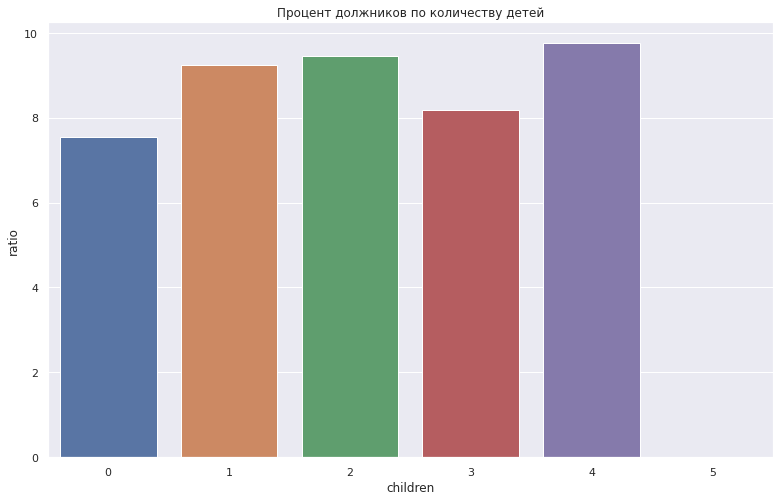

In [22]:
summary_table = data.groupby('children').agg({'debt': 'sum', 'children': 'count'})
summary_table.columns = ['debt', 'num_people_with_children']

summary_table['ratio'] = summary_table['debt'] / summary_table['num_people_with_children'] *100
sns.set_theme(rc={'figure.figsize':(13,8)})
sns.barplot(data=summary_table, x=summary_table.index, y='ratio').set(title='Процент должников по количеству детей')
summary_table['ratio']

**Вывод:** По данной таблице видно, что чем количество детей обратно пропорционально числу задолженностей по кредиту, однако надо учесть, что и людей, у которых меньше детей попросту больше, а вот в ratio четко видно, что особой закономерности нет, кроме варианта, что люди без детей чуть чуть чаще возвращают кредиты (процент должников 7.5%), тогда как у людей с 1 или 2 детьми процент должников 9.2% и 9.5% соответсвенно, однако люди с 3 детьми возвращают кредиты вовремя чаще чем с 1 или 2 детьми, у них процент должников 8.2%. По категориям в 4 и 5 детей слишком мелкая выборка чтобы предоставлять выводы.

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

family_status
Не женат / не замужем    9.763948
в разводе                7.064760
вдовец / вдова           6.624606
гражданский брак         9.313014
женат / замужем          7.560558
Name: ratio, dtype: float64

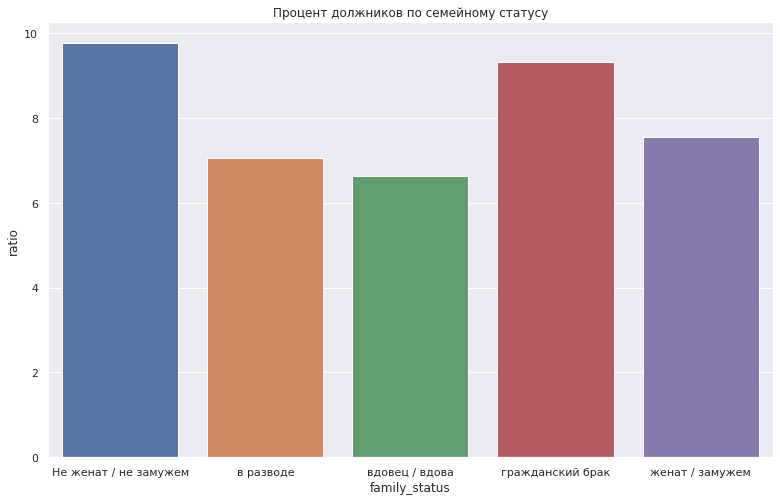

In [23]:
summary_table = data.groupby('family_status').agg({'debt': 'sum', 'family_status': 'count'})
summary_table.columns = ['debt', 'num_family_statuses']

summary_table['ratio'] = summary_table['debt'] / summary_table['num_family_statuses'] *100
sns.set_theme(rc={'figure.figsize':(13,8)})
sns.barplot(data=summary_table, x=summary_table.index, y='ratio').set(title='Процент должников по семейному статусу')
summary_table['ratio']

**Вывод:**  Данная таблица показывает, что закономерность есть, в зависимости от семейного положения разнится шанс, что человек окажется должником, где вдовцы или вдовы чаще всех возвращают долги в срок, далее на 0.5-1% реже возвращают долги те, кто в разводе или женаты, и последнее место разделяют те, кто либо никогда не был женат, либо в гражданском браке, возвращают еще на 2% реже

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

total_income_category
A    8.000000
B    7.060231
C    8.498210
D    6.017192
E    9.090909
Name: ratio, dtype: float64

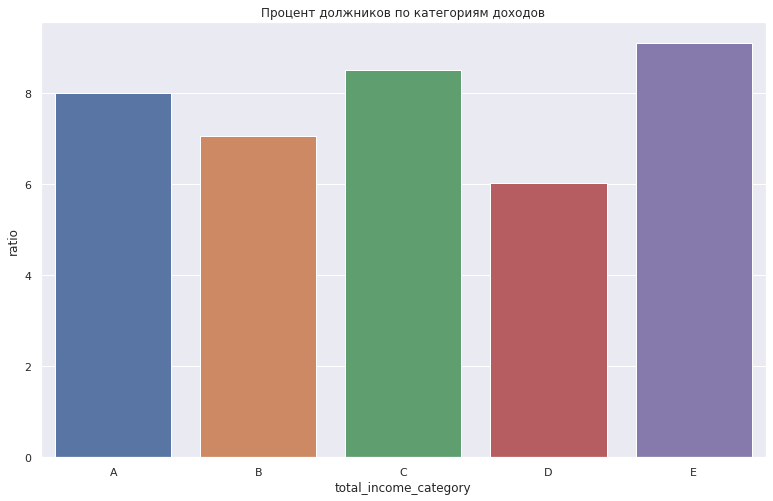

In [24]:
summary_table = data.groupby('total_income_category').agg({'debt': 'sum', 'total_income_category': 'count'})
summary_table.columns = ['debt', 'amount_in_category']

summary_table['ratio'] = summary_table['debt'] / summary_table['amount_in_category'] *100
sns.set_theme(rc={'figure.figsize':(13,8)})
sns.barplot(data=summary_table, x=summary_table.index, y='ratio').set(title='Процент должников по категориям доходов')
summary_table['ratio']

**Вывод:** В данной таблице чтобы делать выводы выборка категории Е и А слишком малы, чтобы делать выводы, однако по категориям В, С и D нет линейной зависимости, наиболее часто вовремя возвращают долги заемщики из категории D, где имеют задолженность только 6%, далее из категории В с процентом должников в 7% и далее из категории В с 8.5% должников по кредитам

#### 3.4 Как разные цели кредита влияют на его возврат в срок?

purpose_category
операции с автомобилем      9.347978
операции с недвижимостью    7.255139
получение образования       9.252758
проведение свадьбы          7.911803
Name: ratio, dtype: float64

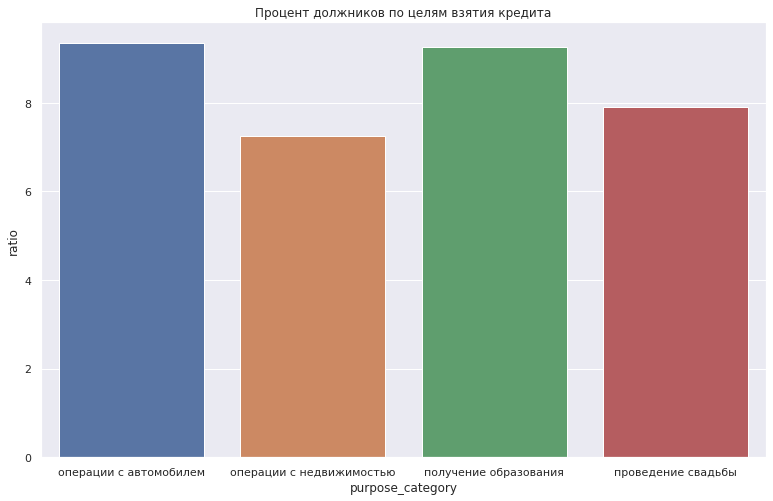

In [25]:
summary_table = data.groupby('purpose_category').agg({'debt': 'sum', 'purpose_category': 'count'})
summary_table.columns = ['debt', 'amount_in_category']

summary_table['ratio'] = summary_table['debt'] / summary_table['amount_in_category'] *100
sns.set_theme(rc={'figure.figsize':(13,8)})
sns.barplot(data=summary_table, x=summary_table.index, y='ratio').set(title='Процент должников по целям взятия кредита')
summary_table['ratio']

**Вывод:** Разные цели влияют, для недвижимости и свадеб возвращают в срок чаще чем для операций с авто или образования

#### Возможные причины появления пропусков в исходных данных.

ошибка тех, кто данные заполнял, нехватка документов, предпочли скрыть изнальные данные при подаче заявлений, ошибки программы с утерей данных

#### Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

На среднее сильно могут повлиять "выбросы", но на медиану сильно разнящиеся значения влияют слабо, что делает их стабильнее

### Общий вывод.

## Была проведена работа со статистикой о платёжеспособности клиентов, предоставленной банком

были выявлены некоторые зависимости в следующих характеристиках: количество детей, уровень дохода, семейное положение, цели кредита

##### процент должников по кредиту в зависимости от количества детей:
0:    7.5%  
1:    9.2%  
2:    9.5%  
3:    8.2%

##### процент должников по кредиту в зависимости от семейного положения:

Не женат / не замужем    9.8%  
в разводе                7.1%  
вдовец / вдова           6.6%  
гражданский брак         9.3%  
женат / замужем          7.6%

##### процент должников по кредиту в зависимости от категории доходов:

B    7.0%  
C    8.5%  
D    6.0%  

##### процент должников по кредиту в зависимости от целей кредита:

операции с автомобилем      9.3%  
операции с недвижимостью    7.3%  
получение образования       9.3%  
проведение свадьбы          7.9%

### идеальным клиентом будет: 
бездетный вдовец или вдова с доходом от 30001 до 50000, который берет кредит на операции с недвижимостью,
а самым худшим по статистике клиентом будет: не женатый(ая) с двумя детьми, доходом от 50001 до 200000, который берет кредит для операций с автомобилем
### для лучшего сбора данных можно:
ужесточить требования заполнения заявлений на кредит, проверить программы и механизмы записи и передачи данных 

также я посмотрел что вы порекомендовали по поводу визуализации и для данного примера на данном этапе ничего лучше обычного barplot я не нашел, а хотелось, максимум что можно это притянуть за уши и в разделе с детьми использовать гистограмму или сделать расширенную версию по доходам, но тогда нужно больше категорий доходов :)